In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model

import sys
from pathlib import Path
sys.path[0] = str(Path(sys.path[0]).parent.parent)

# get TN-PNN model, 
# build TaylorMap with aperture,
# method: nan value for lost particle
# file: tm_pnn -> layers -> Taylor_Map_loss_method_nan
from tm_pnn.layers.Taylor_Map_loss_method_nan import TaylorMap
from tm_pnn.regularization.symplectic import get_reg_term_2_2 as sympl_reg

# import of sis18_cell, ocelot input file
# input tranport matrix form ocelot up to second ordner (file: ocelot_lattice_sis18)
from ocelot_lattice_sis18 import get_transfermaps

# matplotlib parameter
plt.rc('text', usetex=False) 
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rc('axes', linewidth=2)
plt.rc('lines', linewidth=3)


Using TensorFlow backend.


initializing ocelot...


In [2]:
def get_sequential_model(dim, order, dx_list, aperture) :
    model = Sequential()
    dim = 2
    order = 2
    lengths = [0]
    
    # add aperture in TaylotMap
    # method: nan value for lost particle
    # file: tm_pnn - layers - Taylor_Map_loss_method_nan
    for i, (R, T, name, length) in enumerate(get_transfermaps(dim=dim)):
        element_map = TaylorMap(output_dim = dim, order = order, input_shape = (dim,),
                                weights=[np.zeros((1,dim)), R.T, T.T],
                                weights_regularizer=lambda W: sympl_reg(0.009, W),
                                aperture = aperture[i])
        element_map.tag = name

        model.add(element_map)
        lengths.append(length)

    
    lengths = np.cumsum(np.array(lengths))
    print('sequential model is built')
    return model, lengths

# get output of each layer (twiss parameter or par. coordinates),
# an additional element like bmp is not requried
def get_elementwise_model(dim=2, order=2, dx_list=None, aperture=0):
    model, lengths  = get_sequential_model(dim, order, dx_list, aperture)
    model = Model(inputs=model.input, outputs=[el.output for el in model.layers])
    
    return model, lengths

In [3]:
# aperture random chosen
a = np.float32(11e-5)
ad = np.full(23,a)
ad[0:10] = 0.7*a
ad[10:15] = 0.9*a

In [4]:
dim = 2
order = 2

model_ideal, lengths = get_elementwise_model(dim, order, None, aperture=ad) 

sequential model is built


In [5]:
N = 5
X0 = np.zeros((N, dim))
X0[:, 1] = np.linspace(-9e-6, 9e-6, N)
X0[N//2]*=0 # reference track with initial conditions x(0)=0, x'(0)=0


X = np.array(model_ideal.predict(X0))

X = np.vstack((X0[np.newaxis, :], X))


In [6]:
ndarr=X[-1, :, 0]
print('loss', np.isnan(ndarr).sum() , np.isnan(ndarr).sum() / ndarr.size)


loss 2 0.4


Text(0, 0.5, 'x (m)')

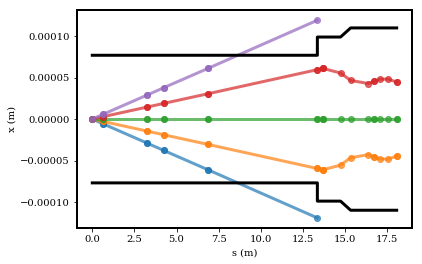

In [7]:
S = plt.plot(lengths, X[:, :, 0], 'o-', alpha=0.7)
plt.plot(lengths,ad, c='k')
plt.plot(lengths,-ad, c='k')
plt.xlabel('s (m)')
plt.ylabel('x (m)')